In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical

In [7]:
# Configuration
IMG_SIZE = 64
DATASET_PATH = r"C:\Users\vmmba\OneDrive\Documents\SignDetection\images_db\Images"   # Replace with your actual dataset path
LABELS = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
NUM_CLASSES = len(LABELS)


In [8]:
# Load OpenCV's hand cascade classifier
hand_cascade = cv2.CascadeClassifier(r"C:\Users\vmmba\OneDrive\Documents\SignDetection\haarcascade_hand.xml")

In [9]:
def preprocess_images():
    data = []
    labels = []

    for label in LABELS:
        folder_path = os.path.join(DATASET_PATH, label)
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            img = cv2.imread(img_path)
            if img is None:
                continue

            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            hands = hand_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

            if len(hands) > 0:
                x, y, w, h = hands[0]  # Take the first detected hand
                hand_img = img[y:y+h, x:x+w]
                hand_img = cv2.resize(hand_img, (IMG_SIZE, IMG_SIZE))
            else:
                hand_img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

            data.append(hand_img)
            labels.append(LABELS.index(label))

    data = np.array(data) / 255.0
    labels = np.array(labels)
    return data, labels

In [14]:
def define_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [15]:
# Load and preprocess the dataset
print("Loading and preprocessing images...")
data, labels = preprocess_images()


Loading and preprocessing images...


In [16]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
y_train = to_categorical(y_train, num_classes=NUM_CLASSES)
y_test = to_categorical(y_test, num_classes=NUM_CLASSES)

In [17]:
# Define and train the model
model = define_model()
print(model.summary())


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 685,386 (2.61 MB)

 Trainable params: 684,938 (2.61 MB)

 Non-trainable params: 448 (1.75 KB)

None


In [18]:
print("Training the model...")
history = model.fit(X_train, y_train, epochs=15, validation_data=(X_test, y_test), batch_size=32)


Training the model...
Epoch 1/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - accuracy: 0.2840 - loss: 3.2485 - val_accuracy: 0.1114 - val_loss: 3.5105
Epoch 2/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.5147 - loss: 1.3699 - val_accuracy: 0.1138 - val_loss: 4.0947
Epoch 3/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.6584 - loss: 0.9913 - val_accuracy: 0.1211 - val_loss: 4.6260
Epoch 4/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.7092 - loss: 0.8108 - val_accuracy: 0.1090 - val_loss: 7.0427
Epoch 5/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - accuracy: 0.7738 - loss: 0.6201 - val_accuracy: 0.0944 - val_loss: 5.2595
Epoch 6/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - accuracy: 0.7975 - loss: 0.5494 - val_accuracy: 0.0920 - val_loss: 7.3878
Epoch 7/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.8089 - loss: 0.5392 - val_accuracy: 0.2470 - val_loss: 3.7323
Epoch 8/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - accuracy: 0.8307 - loss: 0.4

In [19]:
#Evaluate the model
print("Evaluating the model...")
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Evaluating the model...
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8739 - loss: 0.4273
Test Loss: 0.4024352729320526
Test Accuracy: 0.8595641851425171


In [20]:
# Save the model for GUI use
model.save("hand_sign_model.h5")
print("Model saved as hand_sign_model.h5")


Model saved as hand_sign_model.h5


In [21]:
# Confusion Matrix and Classification Report
predictions = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, predictions)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


In [22]:
# Plot Confusion Matrix
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, f"{cm[i, j]}", horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

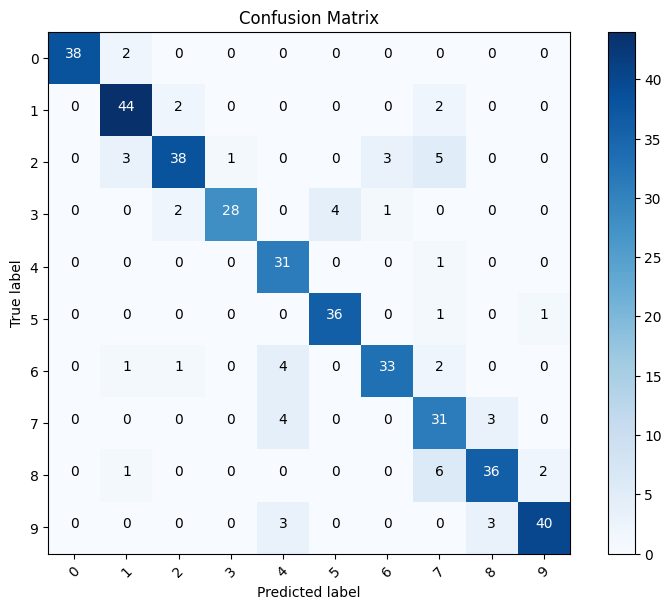

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        40
           1       0.86      0.92      0.89        48
           2       0.88      0.76      0.82        50
           3       0.97      0.80      0.88        35
           4       0.74      0.97      0.84        32
           5       0.90      0.95      0.92        38
           6       0.89      0.80      0.85        41
           7       0.65      0.82      0.72        38
           8       0.86      0.80      0.83        45
           9       0.93      0.87      0.90        46

    accuracy                           0.86       413
   macro avg       0.87      0.86      0.86       413
weighted avg       0.87      0.86      0.86       413



In [23]:
plot_confusion_matrix(cm, LABELS)
print("Classification Report:")
print(classification_report(y_true, predictions, target_names=LABELS))

In [24]:
# Test function to predict any full image
def predict_image(image_path):
    model = load_model("hand_sign_model.h5")
    
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hands = hand_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

    if len(hands) > 0:
        x, y, w, h = hands[0]
        hand_img = img[y:y+h, x:x+w]
        hand_img = cv2.resize(hand_img, (IMG_SIZE, IMG_SIZE))
    else:
        hand_img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    hand_img = np.expand_dims(hand_img / 255.0, axis=0)
    prediction = model.predict(hand_img)
    predicted_class = np.argmax(prediction)

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Predicted Sign: {LABELS[predicted_class]}")
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


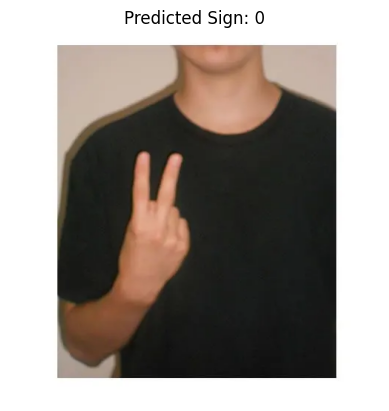

In [25]:
# Example usage
example_image_path = r"C:\Users\vmmba\OneDrive\Documents\SignDetection\images_db\Example\example_09.webp"  # Replace with a test image path
predict_image(example_image_path)